# 1. Original Version

In [3]:
import pandas as pd
import datetime
import json
import os
import numpy as np
import matplotlib.pyplot as plt

# Reading CSV file
df = pd.read_csv("OSB\source\Derveni_et_al_2020_OSB_specimen_list.csv")

# Struct definitions
class Source:
    def __init__(self, authors, date, title, bibtex, units, nominal_data, notes):
        self.authors = authors
        self.date = date
        self.title = title
        self.bibtex = bibtex
        self.units = units
        self.nominal_data = nominal_data
        self.notes = notes
    def to_dict(self):
        return self.__dict__

class Fastener:
    def __init__(self, type_, details):
        self.type = type_
        self.details = details
    def to_dict(self):
        return self.__dict__

class Ply:
    def __init__(self, type_, thickness, elastic_modulus, yield_stress, ultimate_stress):
        self.type = type_
        self.thickness = thickness
        self.elastic_modulus = elastic_modulus
        self.yield_stress = yield_stress
        self.ultimate_stress = ultimate_stress
    def to_dict(self):
        return self.__dict__

class Test:
    def __init__(self, name, loading, force, displacement):
        self.name = name
        self.loading = loading
        self.force = force
        self.displacement = displacement
    def to_dict(self):
        return self.__dict__

class Specimen:
    def __init__(self, source, fastener, ply, test):
        self.source = source
        self.fastener = fastener
        self.ply = ply
        self.test = test
    def to_dict(self):
        return self.__dict__

def convert_to_dict(obj):
    if isinstance(obj, list):
        return [convert_to_dict(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: convert_to_dict(value) for key, value in obj.items()}
    elif isinstance(obj, datetime.date):
        return obj.isoformat()  # Convert date to string format
    elif isinstance(obj, (np.int64, np.int32)):  
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):  
        return float(obj)
    elif isinstance(obj, np.ndarray):  # Add this line
        return obj.tolist()  # Convert ndarray to list
    elif hasattr(obj, "to_dict"):
        return convert_to_dict(obj.to_dict())
    else:
        return obj

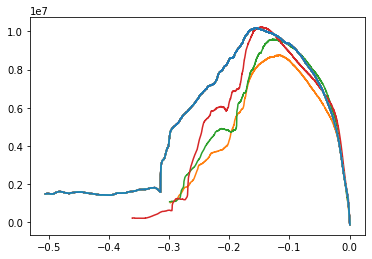

In [1]:
# Source data initialization
authors = ["Peterman, K.D.", "Nakata, N.", "Schafer, B.W."]
date = datetime.date(2014, 10, 1)
title = "Hysteretic characterization of cold-formed steel stud-to-sheathing connections"
bibtex = """@article{peterman2014hysteretic,
title={Hysteretic characterization of cold-formed steel stud-to-sheathing connections},
author={Peterman, KD and Nakata, N and Schafer, BW},
journal={Journal of Constructional Steel Research},
volume={101},
pages={254--264},
year={2014},
publisher={Elsevier}
}"""
units = ["inches", "lbf"]
nominal_data = ["steel ply thickness", "sheathing ply thickness"]
notes = "Zeroed data as average of first 10 load and disp readings.  Multiplied load and disp voltages by factors provided by Kara."

source = Source(authors, date, title, bibtex, units, nominal_data, notes)

all_sources = [source]

num_specimens = 30
fasteners = [None] * num_specimens
plies = [None] * num_specimens

for i in range(num_specimens):
    details = [{"size": df.loc[i, 'fastener_size'], 
                "product name": df.loc[i, 'fastener_name'], 
                "major thread diameter": df.loc[i, 'fastener_diameter']} for _ in range(df.loc[i, 'number_of_fasteners'])]

    fasteners[i] = Fastener(["screw"] * df.loc[i, 'number_of_fasteners'], details)
    plies[i] = Ply([df.loc[i, 'sheathing_type'], "steel"], 
                   [df.loc[i, 'sheathing_thickness'], df.loc[i, 'steel_thickness']], 
                   ["unknown", df.loc[i, 'E']], 
                   ["unknown", df.loc[i, 'steel_ply_fy']], 
                   ["unknown", df.loc[i, 'steel_ply_fu']])

# Read from delimited file
data = np.loadtxt("OSB\source\data\m54o12-R1.txt", delimiter=',')

force = data[:, 2]
displacement = data[:, 1]
name = df.loc[0, 'filename'][:-4]
loading = df.loc[0, 'loading_type']

test = [Test(name, loading, force, displacement) for _ in range(num_specimens)]
first_specimen = Specimen(all_sources, fasteners[0], plies[0], test[0])

all_specimens = [Specimen(all_sources, fasteners[i], plies[i], test[i]) for i in range(num_specimens)]

Lscale = 5.87  # lbf/lbf
Lgain = 851.46  # v/v
Dscale = 0.04075  # in/in
Dgain = 7.3602  # v/v

for i in range(len(test)):
    data = np.loadtxt(os.path.join("OSB\source\data", df.loc[i, 'filename']), delimiter=',')
    name = df.loc[i, 'filename'][:-4]
    loading = df.loc[i, 'loading_type']
    force = (data[:, 2] - np.mean(data[:10, 2])) * Lscale * Lgain
    displacement = -(data[:, 1] - np.mean(data[:10, 1])) * Dscale * Dgain
    test[i] = Test(name, loading, force, displacement)
    all_specimens[i] = Specimen(all_sources, fasteners[i], plies[i], test[i])

json_path = "OSB\json"
with open(os.path.join(json_path, "first_specimen.json"), 'w') as f:
    json.dump(convert_to_dict(first_specimen), f, indent=4)

for i, specimen in enumerate(all_specimens):
    with open(os.path.join(json_path, f"Peterman_et_al_2014_{df.loc[i, 'filename'][:-4]}.json"), 'w') as f:
        json.dump(convert_to_dict(specimen), f, indent=4)

index = 3
plt.plot(test[index].displacement, test[index].force)
for t in test:
    plt.plot(t.displacement, t.force)
plt.show()


In [2]:
for i in range(1, 31):
    filename = f"m54o12-R{i}.txt"
    data_path = os.path.join("OSB\source\data", filename)

    data = np.loadtxt(data_path, delimiter=',')

    name = df.loc[i-1, 'filename'][:-4]
    loading = df.loc[i-1, 'loading_type']
    
    force = (data[:, 2] - np.mean(data[:10, 2])) * Lscale * Lgain
    displacement = -(data[:, 1] - np.mean(data[:10, 1])) * Dscale * Dgain

    test[i-1] = Test(name, loading, force, displacement)
    all_specimens[i-1] = Specimen(all_sources, fasteners[i-1], plies[i-1], test[i-1])

    json_filename = f"Peterman_et_al_2014_{name}_{i}.json"
    json_path_full = os.path.join(json_path, json_filename)
    with open(json_path_full, 'w') as f:
        json.dump(convert_to_dict(all_specimens[i-1]), f, indent=4)

# 2. Put Everything into Function

Still something went wrong

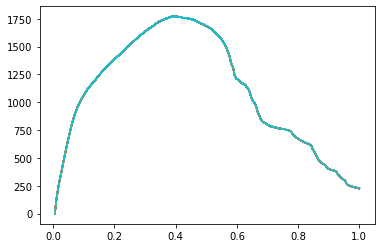

In [4]:
def initialize_source(authors, date, title, bibtex, units, nominal_data, notes):
    source = Source(authors, date, title, bibtex, units, nominal_data, notes)
    return source

def load_data(filename):
    df = pd.read_csv(filename)
    return df

def initialize_fasteners(df, num_specimens):
    fasteners = [None] * num_specimens

    for i in range(num_specimens):
        details = [{"size": df.loc[i, 'fastener_size'], 
                    "product name": df.loc[i, 'fastener_name'], 
                    "major thread diameter": df.loc[i, 'fastener_diameter']} for _ in range(df.loc[i, 'number_of_fasteners'])]

        fasteners[i] = Fastener(["screw"] * df.loc[i, 'number_of_fasteners'], details)
        
    return fasteners

def initialize_plies(df, num_specimens):
    plies = [None] * num_specimens

    for i in range(num_specimens):
        plies[i] = Ply([df.loc[i, 'sheathing_type'], "steel"], 
                       [df.loc[i, 'sheathing_thickness'], df.loc[i, 'steel_thickness']], 
                       ["unknown", df.loc[i, 'E']], 
                       ["unknown", df.loc[i, 'steel_ply_fy']], 
                       ["unknown", df.loc[i, 'steel_ply_fu']])
        
    return plies

def initialize_test(df, num_specimens, data):
    test = [None] * num_specimens
    force = data[:, 2]
    displacement = data[:, 1]

    for i in range(num_specimens):
        name = df.loc[i, 'filename'][:-4]
        loading = df.loc[i, 'loading_type']
        test[i] = Test(name, loading, force, displacement)
        
    return test

def initialize_specimens(all_sources, fasteners, plies, test):
    num_specimens = len(fasteners)
    all_specimens = [None] * num_specimens

    for i in range(num_specimens):
        all_specimens[i] = Specimen(all_sources, fasteners[i], plies[i], test[i])
        
    return all_specimens

def save_as_json(specimen, json_path, filename):
    with open(os.path.join(json_path, filename), 'w') as f:
        json.dump(convert_to_dict(specimen), f, indent=4)

def plot_force_displacement(test):
    for t in test:
        plt.plot(t.displacement, t.force)
    plt.show()

json_path = "OSB\json"

# Source data initialization
authors = ["Peterman, K.D.", "Nakata, N.", "Schafer, B.W."]
date = datetime.date(2014, 10, 1)
title = "Hysteretic characterization of cold-formed steel stud-to-sheathing connections"
bibtex = """@article{peterman2014hysteretic,
title={Hysteretic characterization of cold-formed steel stud-to-sheathing connections},
author={Peterman, KD and Nakata, N and Schafer, BW},
journal={Journal of Constructional Steel Research},
volume={101},
pages={254--264},
year={2014},
publisher={Elsevier}
}"""
units = ["inches", "lbf"]
nominal_data = ["steel ply thickness", "sheathing ply thickness"]
notes = "Zeroed data as average of first 10 load and disp readings.  Multiplied load and disp voltages by factors provided by Kara."

source = initialize_source(authors, date, title, bibtex, units, nominal_data, notes)
all_sources = [source]

df = load_data("OSB\source\Derveni_et_al_2020_OSB_specimen_list.csv")

num_specimens = 30
fasteners = initialize_fasteners(df, num_specimens)
plies = initialize_plies(df, num_specimens)

data = np.loadtxt("OSB\source\data\m54o12-R1.txt", delimiter=',')
test = initialize_test(df, num_specimens, data)
first_specimen = Specimen(all_sources, fasteners[0], plies[0], test[0])

all_specimens = initialize_specimens(all_sources, fasteners, plies, test)

save_as_json(first_specimen, json_path, "first_specimen.json")

for i, specimen in enumerate(all_specimens):
    filename = f"Peterman_et_al_2014_{df.loc[i, 'filename'][:-4]}.json"
    save_as_json(specimen, json_path, filename)

index = 3
plot_force_displacement(test)

# 3. Some Useless Visualization

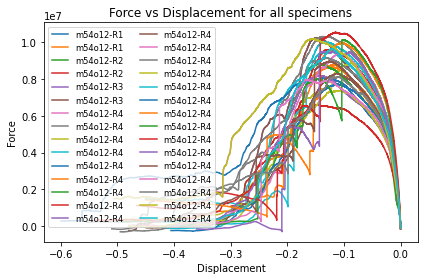

In [3]:
import json
import os
import matplotlib.pyplot as plt

json_path = "OSB\json"
all_specimens = []
json_list = os.listdir(json_path)
for i in range(1, 31):
    json_filename = json_list[i]
    json_path_full = os.path.join(json_path, json_filename)
    with open(json_path_full, 'r') as f:
        specimen_data = json.load(f)
        all_specimens.append(specimen_data)

for specimen in all_specimens:
    plt.plot(specimen['test']['displacement'], specimen['test']['force'], label=specimen['test']['name'])

plt.xlabel('Displacement')
plt.ylabel('Force')
plt.legend(loc='best', fontsize='small', ncol=2)
plt.title('Force vs Displacement for all specimens')
plt.tight_layout()
plt.show()


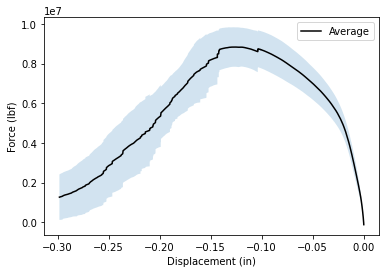

In [6]:
all_forces = [specimen['test']['force'] for specimen in all_specimens]
all_displacements = [specimen['test']['displacement'] for specimen in all_specimens]

min_length = min(len(force) for force in all_forces)

truncated_forces = [force[:min_length] for force in all_forces]
truncated_displacements = [displacement[:min_length] for displacement in all_displacements]

mean_force = np.mean(truncated_forces, axis=0)
std_force = np.std(truncated_forces, axis=0)

plt.fill_between(truncated_displacements[0], mean_force - std_force, mean_force + std_force, alpha=0.2)
plt.plot(truncated_displacements[0], mean_force, 'k-', label='Average')
plt.xlabel('Displacement (in)')
plt.ylabel('Force (lbf)')
plt.legend()
plt.show()

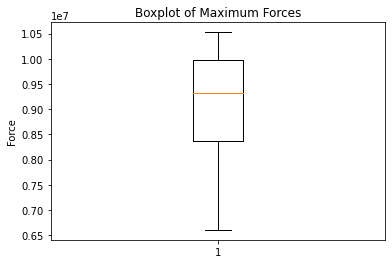

In [7]:
max_forces = [max(specimen['test']['force']) for specimen in all_specimens]

plt.boxplot(max_forces)
plt.title('Boxplot of Maximum Forces')
plt.ylabel('Force')
plt.show()

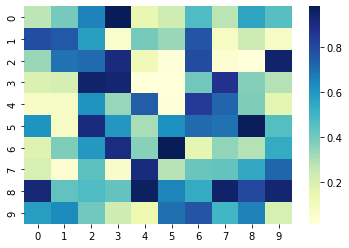

In [8]:
import seaborn as sns

heatmap_data = np.random.rand(10, 10)

sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.show()

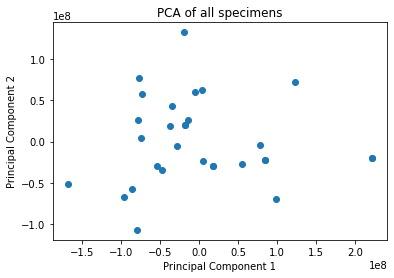

In [12]:
from sklearn.decomposition import PCA

min_length = min(len(specimen['test']['force']) for specimen in all_specimens)
X = np.array([np.pad(specimen['test']['force'], (0, max(0, min_length - len(specimen['test']['force']))), 'constant')[:min_length] for specimen in all_specimens])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of all specimens')
plt.show()

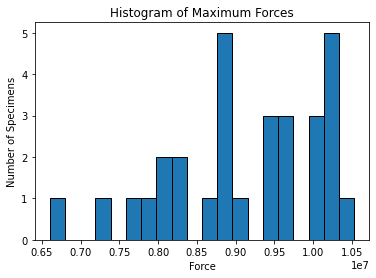

In [11]:
plt.hist(max_forces, bins=20, edgecolor='k')
plt.title('Histogram of Maximum Forces')
plt.xlabel('Force')
plt.ylabel('Number of Specimens')
plt.show()